# Analysis 1.1
- Model: CoxPH 
- Feature selection: Significant variables based on univariate analysis
- Drop patients with missing sex 
- Predicts 3 year risk for combined UGI cancer
- Risk score threshold determined on 1) 4th quartile and 2) optimal threshold 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.stats import percentileofscore
from pathlib import Path
from functools import reduce
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
source("utils.R")
library(survival)
library(bshazard)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
model = 'coxph'
cancer = 'ugica'
ro.globalenv['cancer'] = cancer

analysis_num = '1.1'

In [8]:
%%R
outcome_intervals <- c("_3yr", "_5yr", "_10yr")
outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_events <- lapply(outcome_intervals, function(interval) paste0(tolower(cancer), interval))
outcome_events <- unlist(outcome_events)

In [9]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [10]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
model_filename = f'{model}_{cancer}.rds'

In [11]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)
ro.globalenv['model_filename'] = model_filename

## Univariate analysis

### Factorize categorical vars and set reference levels

In [12]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [13]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [14]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    model <- train_coxph_model(r_df_normal, var, outcome)
    model_df <- get_coxph_univariate_summary(model, var, categorical_vars)

    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

In [15]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [16]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable_full,Variable,Level,HR,CI_lower,CI_upper,p_value
0,sex_missing,sex_missingMALE,sex_missing,MALE,1.981637,1.558041,2.520398,2.492423e-08
1,race_clean.race_cleanAsian,race_cleanAsian,race_clean,Asian,1.746678,1.140449,2.675161,1.034142e-02
2,race_clean.race_cleanBlack or African American,race_cleanBlack or African American,race_clean,Black or African American,0.719336,0.524997,0.985612,4.034913e-02
6,ethnicity.ethnicityNo matching concept,ethnicityNo matching concept,ethnicity,No matching concept,0.648537,0.421466,0.997946,4.891696e-02
7,alcohol_binary,alcohol_binary1,alcohol_binary,1,1.402518,1.074902,1.829986,1.269920e-02
12,pud,pud1,pud,1,3.037376,2.145262,4.300479,3.800131e-10
13,gerd,gerd1,gerd,1,1.469313,1.123378,1.921777,4.964092e-03
14,cad,cad1,cad,1,0.744095,0.569118,0.972869,3.069059e-02
15,famhx_cancer,famhx_cancer1,famhx_cancer,1,2.051195,1.641769,2.562724,2.544665e-10
16,famhx_gastricca,famhx_gastricca1,famhx_gastricca,1,5.135876,3.297779,7.998480,4.512079e-13


## Feature selection

In [17]:
%%R 
selected_vars <- final_results %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "alcohol_binary" 
 [5] "pud"             "gerd"            "cad"             "famhx_cancer"   
 [9] "famhx_gastricca" "famhx_colonca"   "ASA"             "PPI"            


### Forest plot for univariate visualization

In [18]:
%%R 
forestplot_df <- final_results[final_results$Variable %in% selected_vars, ]

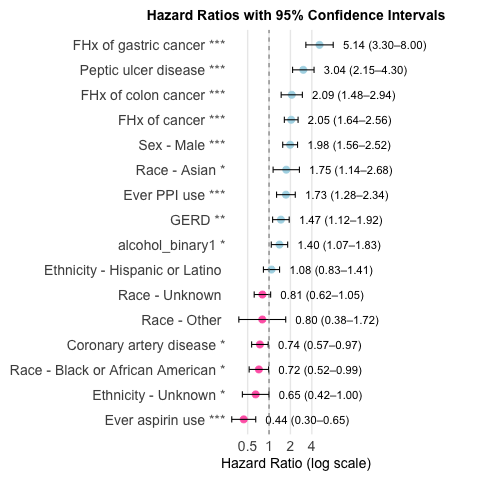

In [19]:
%%R 
pretty_names <- c(
"ethnicityNo matching concept" = "Ethnicity - Unknown",
"alcohol_all2.0" = "Alcohol Use - Current",
"alcohol_all1.0" = "Alcohol Use - Prior",
"alcohol_allNo matching concept" = "Alcohol Use - Unknown",
"ASA1" = "Ever aspirin use",
"tobacco_binary1.0" = "Ever tobacco use",
"NSAID1" = "Ever NSAID use",
"hgb_imputed_scaled" = "Most recent hemoglobin",
"race_cleanOther" = "Race - Other",
"race_cleanNA" = "Race - Unknown",
"ethnicityHispanic or Latino" = "Ethnicity - Hispanic or Latino",
"race_cleanBlack or African American" = "Race - Black or African American",
"age_scaled" = "Age",
"alcohol_binary_missing:tobacco_binary1.0" = "Alcohol + tobacco use interaction",
"race_cleanAsian" = "Race - Asian",
"race_cleanNo matching concept" = "Race - Unknown",
"sex_missingMALE" = "Sex - Male",
"famhx_gastricca1" = "FHx of gastric cancer",
"hpylori_binary1.0" = "Active or chronic H.pylori infection",
"PPI1" = "Ever PPI use",
"barretts1" = "Barretts esophagus",
"cad1" = "Coronary artery disease", 
"famhx_cancer1" = "FHx of cancer",
"famhx_colonca1" = "FHx of colon cancer",
"gerd1" = "GERD",
"pud1" = "Peptic ulcer disease"
)

# Define color and label formatting
forestplot_df <- forestplot_df %>%
  mutate(
    Variable_pretty = pretty_names[Variable_full],
    Variable_pretty = ifelse(is.na(Variable_pretty), Variable_full, Variable_pretty),
    sig = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    hr_label = sprintf("%.2f (%.2f–%.2f)", HR, CI_lower, CI_upper),
    Variable_labeled = paste0(Variable_pretty, " ", sig),  # add asterisks here
    color_group = ifelse(HR >= 1, "HR > 1", "HR < 1")
  ) %>%
  arrange(HR) %>%
  mutate(Variable_labeled = factor(Variable_labeled, levels = unique(Variable_labeled)))

# Plot
ggplot(forestplot_df, aes(x = HR, y = Variable_labeled)) +
  geom_point(aes(color = color_group), size = 3) +
  geom_errorbarh(aes(xmin = CI_lower, xmax = CI_upper), height = 0.25) +
  geom_text(aes(x = CI_upper * 1.05, label = hr_label), hjust = -0.1, size = 4) +  # Shows HR + CI
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray50") +
  coord_cartesian(clip = "off") + 
  scale_color_manual(
    values = c("HR > 1" = "lightblue", "HR < 1" = "hotpink"),
    guide = "none"
  ) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = c("0.5", "1", "2", "4"),
    expand = expansion(mult = c(0, 0.25))  # Make room for right-side labels
  ) +
  labs(
    title = "Hazard Ratios with 95% Confidence Intervals",
    x = "Hazard Ratio (log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 14),
    plot.title.position = "panel",
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.x = element_blank(),
    plot.margin = margin(10, 120, 10, 10)  # top, right, bottom, left (in pts)
  )



## CoxPH multivariate model training

#### Split dataset into training and validation

In [20]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
cox_model <- train_coxph_model(train_set, selected_vars, outcome)

[1] "Dataset Controls 33871" "Dataset Cases 312"     
[1] "Training Controls 27103" "Training Cases 244"     
[1] "Validation Controls 6768" "Validation Cases 68"     



#### Test proportional hazards assumption

In [21]:
%%R 
ph_test <- cox.zph(cox_model)
cat("\nVariables with p < 0.05:\n")
print(ph_test$table[ph_test$table[, "p"] < 0.05, ])


Variables with p < 0.05:
                   chisq df           p
famhx_cancer    4.991992  1 0.025464875
famhx_gastricca 7.693897  1 0.005540786
famhx_colonca   4.008747  1 0.045264777


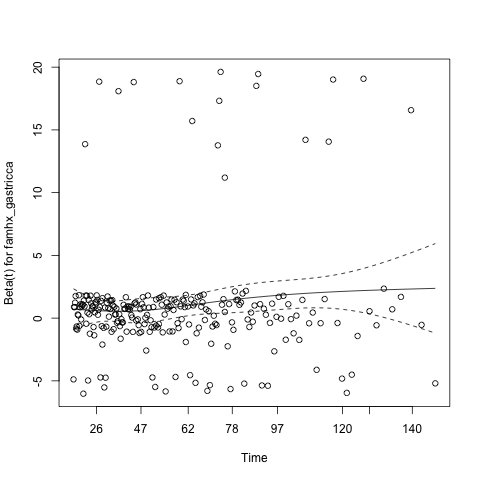

In [22]:
%%R
# Test proportional hazards
zph <- cox.zph(cox_model)
plot(zph, var='famhx_gastricca')   # visualize residuals over time

Surv(months_to_event, ugica) ~ sex_missing + race_clean + ethnicity + 
    alcohol_binary + pud + gerd + cad + famhx_cancer + famhx_gastricca + 
    famhx_colonca + ASA + PPI + famhx_gastricca:log_time

Variables with p < 0.05:
     chisq df p


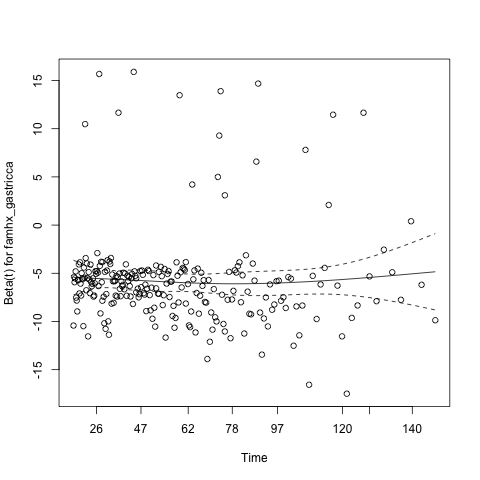

In [23]:
%%R 
train_set$log_time <- log(train_set$months_to_event +0.01)

formula_str <- paste("Surv(months_to_event, ", outcome, ") ~", 
    paste(selected_vars, collapse = " + "), 
    paste("+ famhx_gastricca:log_time"))
formula <- as.formula(formula_str)
print(formula)
time_varying_coxph <- coxph(formula, data = train_set)
time_varying_ph_test <- cox.zph(time_varying_coxph)

cat("\nVariables with p < 0.05:\n")
print(time_varying_ph_test$table[time_varying_ph_test$table[, "p"] < 0.05, ])

plot(time_varying_ph_test, var='famhx_gastricca')   # visualize residuals over time

In [24]:
%%R 
anova(cox_model, time_varying_coxph, test = "LRT")


Analysis of Deviance Table
 Cox model: response is  Surv(months_to_event, ugica)
 Model 1: ~ sex_missing + race_clean + ethnicity + alcohol_binary + pud + gerd + cad + famhx_cancer + famhx_gastricca + famhx_colonca + ASA + PPI
 Model 2: ~ sex_missing + race_clean + ethnicity + alcohol_binary + pud + gerd + cad + famhx_cancer + famhx_gastricca + famhx_colonca + ASA + PPI + famhx_gastricca:log_time
    loglik  Chisq Df Pr(>|Chi|)    
1 -2135.61                         
2  -729.58 2812.1  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Family history of gastric cancer violated the proportional hazards assumption, meaning that the risk from famly history of developing UGI cancer varied over time (ex. higher risk earlier in life if you have family history but less so later in life). This is shown by the residual plot changing slopes over time. 

Adding a time-varying interaction term for family history of gastric cancer led to better fit (based on likelihood ratio test) and resolution of PH test violations.

#### Multivariate analysis

In [25]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_results(cox_model, multivariate_filename)


Multivariate results saved to ./../results/multivariate_analysis_1.1_ugica.csv 


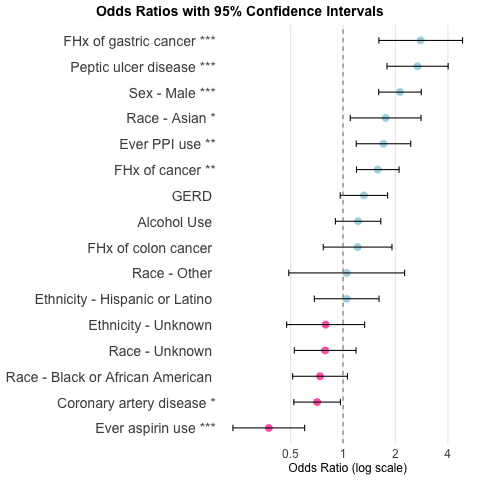

In [26]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [27]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)

# Get the predicted risk 
pred_risk <- calculate_risk_from_coxph(cox_model, validation_set)
r_df_validation_risk$pred_risk <- pred_risk

# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


### Sensitivity and Metrics at threshold that maximizes Youdens

In [28]:
%%R
optimal_thresholds_df <- data.frame()

best_model <- ""
highest_auroc <- 0

for (outcome_event in outcome_events) {
  print(outcome_event)
  actual_event <- r_df_validation_risk[[outcome_event]]

  # Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
  roc_obj <- roc(response = actual_event, predictor = pred_risk)
  optimal_threshold <- coords(
    roc_obj,
    x = "best",
    best.method = "youden",
    transpose = FALSE
  )$threshold

  # Get the AUROC
  auroc <- auc(roc_obj)
  cat("\nAUROC:", auroc, "\n")

  if (auroc > highest_auroc) {
    best_model <- outcome_event
    highest_auroc <- auroc
  }

  # Store the optimal threshold in the dictionary
  optimal_thresholds_df[outcome_event, "optimal_threshold"] <- optimal_threshold

  cat("\nSensitivity and Metrics at Threshold set by Youden index")
  calculate_cm_by_percentile(pred_risk, actual_event, optimal_threshold)
  
  plot_roc_gg(actual_event, pred_risk)
}

[1] "ugica_3yr"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




AUROC: 0.8148936 

Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.815 
Sensitivity: 0.8333333 
Specificity: 0.7361396 
PPV: 0.008269019 
NPV: 0.9994026 
NNS: 130.3501 
     predicted_class
event    0    1
    0 5019 1799
    1    3   15
[1] "ugica_5yr"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




AUROC: 0.8026872 

Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.803 
Sensitivity: 0.85 
Specificity: 0.6962919 
PPV: 0.01620591 
NPV: 0.9987336 
NNS: 66.93641 
     predicted_class
event    0    1
    0 4732 2064
    1    6   34
[1] "ugica_10yr"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




AUROC: 0.7322352 

Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.732 
Sensitivity: 0.7377049 
Specificity: 0.6969742 
PPV: 0.021449 
NPV: 0.996623 
NNS: 55.33408 
     predicted_class
event    0    1
    0 4722 2053
    1   16   45


### AUROC curves and PR curve

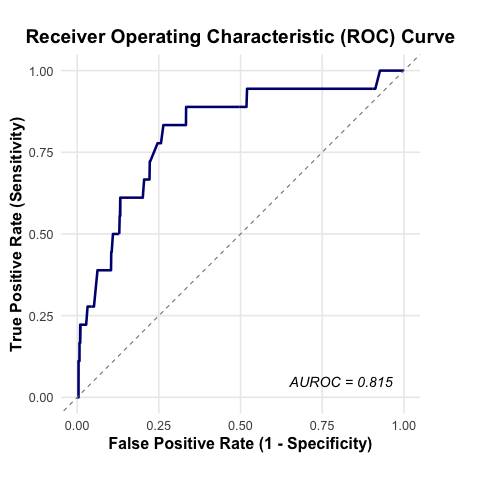

In [29]:
%%R 
actual_event <- r_df_validation_risk[[best_model]]
# Generate all plots
p1 <- plot_roc_gg(actual_event, pred_risk)
p1

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [30]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'


optimal_thresholds_df = pandas2ri.rpy2py(r['optimal_thresholds_df'])
optimal_thresholds_df['optimal_threshold_percentile'] = optimal_thresholds_df['optimal_threshold'].apply(
    lambda x: percentileofscore(df_validation_risk[pred_risk], x, kind='weak') / 100.
)

percentile_cutoffs = [0, 0.2, .5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 1] 
percentile_cutoffs += optimal_thresholds_df['optimal_threshold_percentile'].tolist()
print(percentile_cutoffs)

outcome_intervals = r['outcome_intervals']
outcome_events = list(r['outcome_events'])

# Set youden threshold
best_model = r['best_model']
optimal_threshold = float(optimal_thresholds_df.loc[best_model, 'optimal_threshold'])

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_15033/2734116900.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  optimal_threshold = float(optimal_thresholds_df.loc[best_model, 'optimal_threshold'])


[0, 0.2, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 1, 0.7346401404330019, 0.6930953774136923, 0.6930953774136923]


In [31]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for outcome_interval in outcome_intervals:
    for risk_group in risk_groups:
        events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']

        for event in events: 
            row = classification_metrics(df_validation_risk, risk_group, event)
            results_dataframe.append(row)
        
for outcome_event in outcome_events: 

    # Get summary statistics for each race 
    for race in race_groups:
        df_risk_race = df_validation_risk[df_validation_risk.race == race]

        row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
        results_dataframe.append(row)

    # Get summary statistics for each sex 
    for sex in sex_groups:
        df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

        row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
        results_dataframe.append(row)

    # Get summary statistics for each age
    for age_bucket in age_groups:
        df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

        row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
        results_dataframe.append(row)

    # Get summary statistics for visit year ranges
    for visit_year_bucket in visit_year_groups:
        df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

        row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
        results_dataframe.append(row)

    df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

In [32]:
df_results.risk_percentile.unique()

array([0.2, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 1.0,
       0.7346401404330019, 0.6930953774136923, 'youden'], dtype=object)

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [33]:
for outcome_event in outcome_events:
    optimal_threshold_percentile = float(optimal_thresholds_df.loc[outcome_event, 'optimal_threshold_percentile'])
    filtered_results = df_results[(df_results['risk_percentile'] == optimal_threshold_percentile) & 
                                  (df_results['event'] == outcome_event)]
    display(filtered_results)

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
55,risk_p0.7346401404330019,0.73464,ugica_3yr,all,6818,18,1814,15 (0.8%),0.8,15,1799,3,5019,0.736396,0.263604,83.333333,73.613963,0.826902,99.940263,130.350103,0.569473


,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
130,risk_p0.6930953774136923,0.693095,ugica_5yr,all,6796,40,2098,34 (1.6%),1.6,34,2064,6,4732,0.697191,0.302809,85.0,69.629194,1.620591,99.873364,66.936406,0.546292
135,risk_p0.6930953774136923,0.693095,ugica_5yr,all,6796,40,2098,34 (1.6%),1.6,34,2064,6,4732,0.697191,0.302809,85.0,69.629194,1.620591,99.873364,66.936406,0.546292


,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
200,risk_p0.6930953774136923,0.693095,ugica_10yr,all,6775,61,2098,45 (2.1%),2.1,45,2053,16,4722,0.697338,0.302662,73.770492,69.697417,2.1449,99.662305,55.334076,0.434679
205,risk_p0.6930953774136923,0.693095,ugica_10yr,all,6775,61,2098,45 (2.1%),2.1,45,2053,16,4722,0.697338,0.302662,73.770492,69.697417,2.1449,99.662305,55.334076,0.434679


In [34]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [35]:
%%R 
# Save model
saveRDS(time_varying_coxph, model_filename)

In [36]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    outcome_event: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json


### Prevalance of cancer as a function of risk percentile by subtype

In [37]:
best_model

array(['ugica_3yr'], dtype='<U9')

In [38]:
event_pretty_label = {
    "ugica_3yr": "UGI cancer", 
    "escc_3yr": "Esophageal SCC",
    "eac_3yr": "Esophageal AC",
    "cgc_3yr": "Cardia Gastric AC",
    "ncgc_3yr": "Noncardia Gastric AC"
}
events = event_pretty_label.keys()

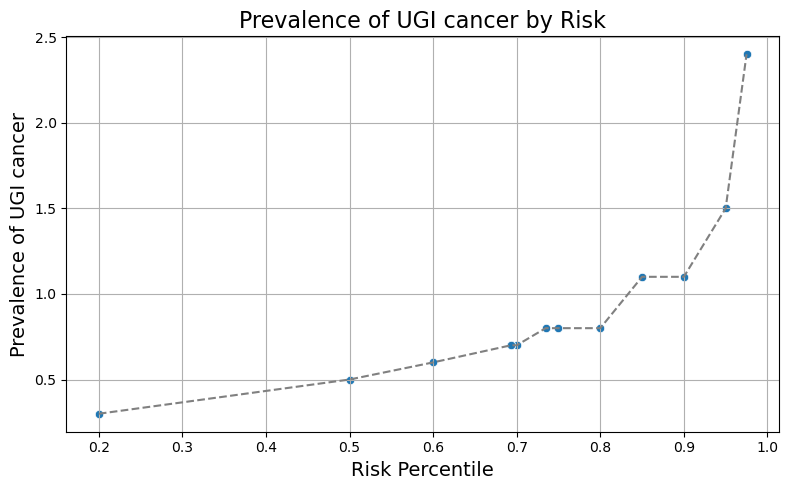

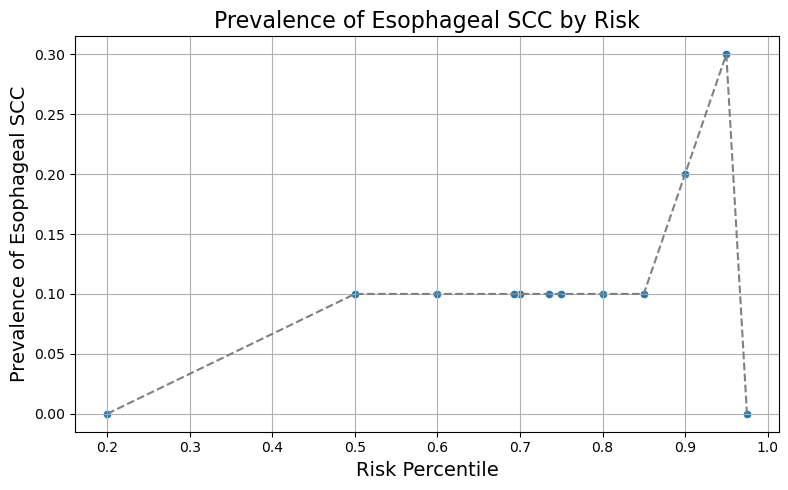

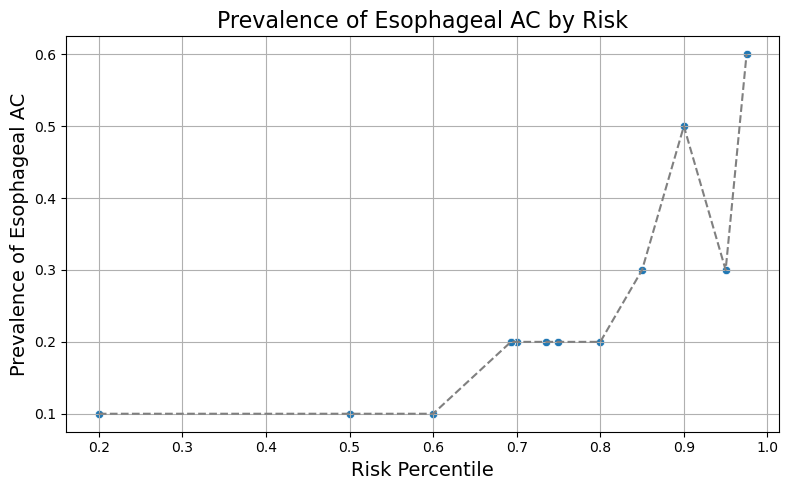

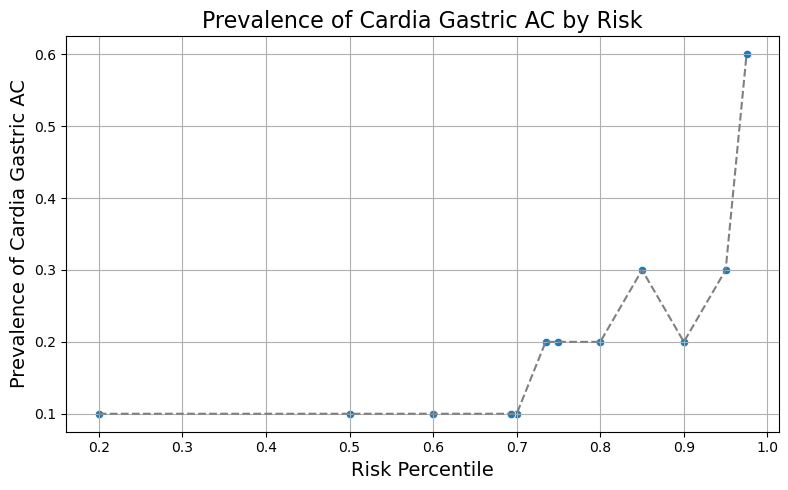

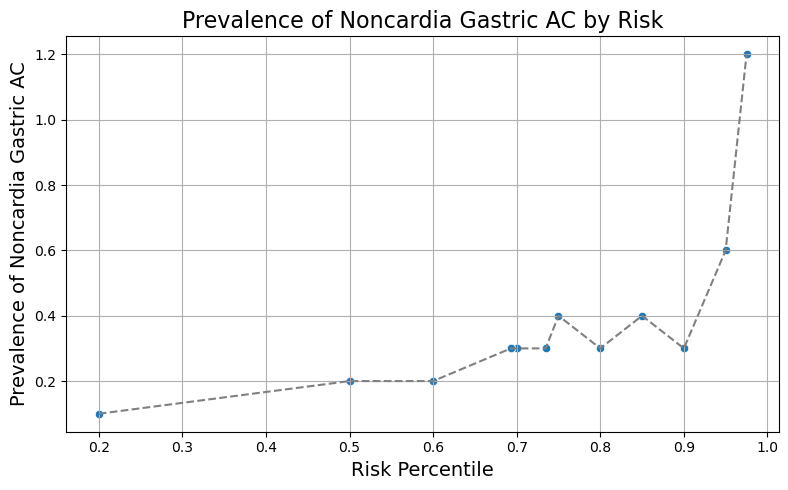

In [39]:
df_results_plot = df_results[df_results['risk_percentile'] != 'youden']

for event in events:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')


    # Axis labels and title
    plt.xlabel("Risk Percentile", fontsize=14)
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}', fontsize=14)
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Kaplan Meier survival curves stratified by risk group

In [40]:
outcome_event = best_model[0]
optimal_threshold_percentile = optimal_thresholds_df.loc[outcome_event, 'optimal_threshold_percentile']
print(outcome_event)

ugica_3yr


In [41]:
pd.crosstab(df_validation_risk[outcome_event], df_validation_risk[f'risk_p{optimal_threshold_percentile}'])

risk_p0.7346401404330019,0,1
ugica_3yr,,
0.0,5019,1799
1.0,3,15


In [42]:
pd.crosstab(df_validation_risk[outcome_event], df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_3yr,,
0.0,5019,1799
1.0,3,15


In [43]:
# Pass dataframe to R to analyze
pass_df(df_validation_risk, 'r_df_validation_risk')

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "risk_group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


#### Kaplan-Meier curve stratified by risk determined by Youden's

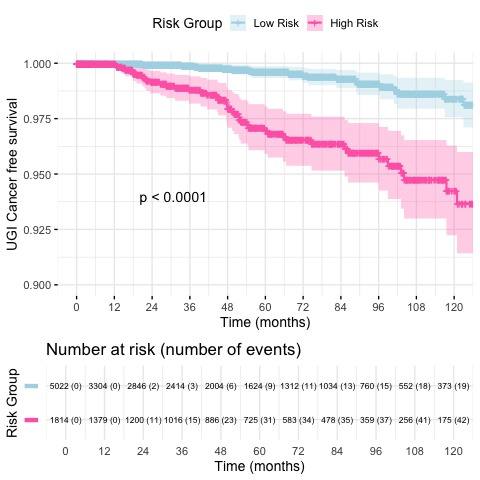

In [44]:
%%R
library(survival)
library(survminer)

surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
  fit,
  data = r_df_validation_risk,
  risk.table = 'nrisk_cumevents', # TRUE for just risk counts
  cumcensor = FALSE,
  cumevents = FALSE,
  pval = TRUE,
  pval.coord = c(20, 0.94),  # adjust as needed
  conf.int = TRUE,
  xlab = "Time (months)",
  ylab = "UGI Cancer free survival",
  xlim = c(0, 120),
  ylim = c(0.90, 1),
  break.time.by = 12,
  legend.title = "Risk Group",
  legend.labs = c("Low Risk", "High Risk"),
  ggtheme = theme_minimal(base_size = 14),
  palette = c("lightblue", "hotpink"),
  risk.table.height = 0.3,
  risk.table.y.text.col = TRUE, # shows risk group label as color 
  risk.table.y.text = FALSE, # shows risk group label as text 
  risk.table.fontsize = 3
)

print(g)


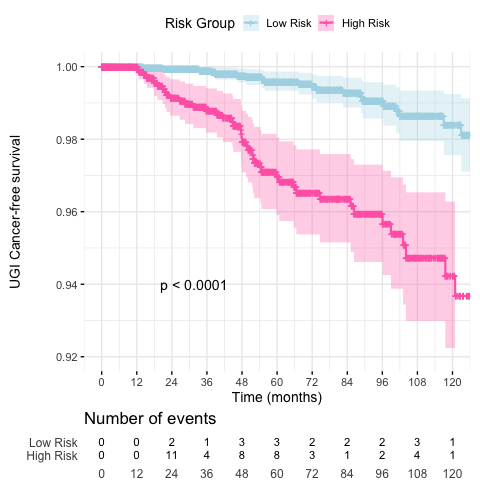

In [45]:
%%R
library(survival)
library(survminer)
library(ggplot2)
library(ggpubr)
library(dplyr)

# Kaplan-Meier survival object
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

# Get cumulative number of events at specified times
event_table <- summary(fit, times = seq(0, 120, by = 12))  # match x-axis ticks
event_df <- data.frame(
  time = event_table$time,
  events = event_table$n.event,
  strata = event_table$strata
) %>%
  tidyr::pivot_wider(names_from = strata, values_from = events)

# Create a data frame for annotation text
event_df_long <- event_df %>%
  tidyr::pivot_longer(cols = -time, names_to = "Group", values_to = "Events")

event_df_long$Group <- recode(event_df_long$Group,
  `high_risk_youden=0` = "Low Risk",
  `high_risk_youden=1` = "High Risk"
)


# Plot Kaplan-Meier curve with ggsurvplot (without built-in risk table)
g_surv <- ggsurvplot(
  fit,
  data = r_df_validation_risk,
  conf.int = TRUE,
  pval = TRUE,
  pval.coord = c(20, 0.94),
  xlim = c(0, 120),
  ylim = c(0.92, 1),
  break.time.by = 12,
  xlab = "Time (months)",
  ylab = "UGI Cancer-free survival",
  legend.title = "Risk Group",
  legend.labs = c("Low Risk", "High Risk"),
  ggtheme = theme_minimal(base_size = 14),
  palette = c("lightblue", "hotpink"),
  risk.table = FALSE  # we will add a custom table instead
)

# Create a custom event table plot
g_events <- ggplot(event_df_long, aes(x = time, y = Group, label = Events)) +
  geom_text(size = 4) +
  scale_x_continuous(limits = c(0, 120), breaks = seq(0, 120, 12)) +
  labs(x = NULL, y = NULL, title= "Number of events") +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(size = 12),
    axis.text.x = element_text(size = 12),
    panel.grid = element_blank(),
    axis.ticks = element_blank(),
    plot.margin = margin(0, 10, 0, 10)
  )

# Combine KM plot and event count table
ggarrange(g_surv$plot, g_events, ncol = 1, heights = c(3, 0.5), align = "v")


### Save model, threshold and validation set

In [46]:
%%R 
# Save model
saveRDS(cox_model, "coxph_all.rds")

In [47]:
# Save optimal threshold 
import json
import os

def save_to_json(variable, filename, key=None):
    # If the file exists, load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    # Append or update data
    if key in data:
        data[key].update(variable)
    else: 
        data[key] = variable

    # Save the updated data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Saved to {filename}")


In [48]:
model = 'coxph'
subtype = 'combined'
selected_vars = list(r['selected_vars'])  

model_variables = {
    subtype: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
